Consider a drainage channel made with a single sheet of metal. The channel is open on top and is required to carry the largest amount of water possible. We wish to compute the base width of the channel $b$, as well as the angle $\theta$ at which the sides should be bent upwards in order to maximize the cross-sectional area.  We assume the width of the metal sheet is $W = 3$m, so we require $2a+b=W$.

## Question 1: Problem Setup
First, we compute an expression for the cross-sectional area of the channel $A$ as a function of the base length $b$ and the angle at which the sides are bent upwards $\theta$.

We know the vertical height of the cross-section to be $a \sin(\theta)$. Similarly, the area jutting out beneath the bent sides are $a \cos(\theta)$ on both sides. Furthermore, we know $2a+b=3 \implies a = \frac{3 - b}{2}$. 
This gives the total area as 
$$ A(b,\theta) = ab \sin(\theta) + a^2 \sin(\theta)  \cos(\theta)  = a \sin(\theta) \big(b+a\cos (\theta) \big) = \frac{1}{4}(b-3) \sin(\theta) \big((b-3)\cos(\theta) - 2b \big)$$


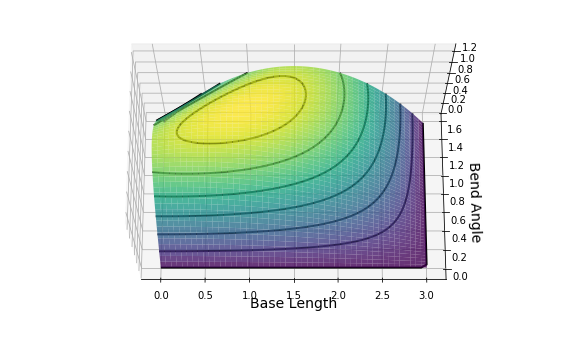

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

b = np.linspace(0, 3)
theta = np.linspace(0, np.pi/2)
b, theta = np.meshgrid(b, theta)

area =  0.5 * (3-b) * np.sin(theta) * (b + 0.5 * (3-b)* np.cos(theta))

fig = plt.figure(figsize = (10, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(b, theta, area, cmap = 'viridis', 
                       linewidth = 0.01, antialiased = True, alpha = 0.8)
cset = ax.contour(b, theta, area, zdir='b',  colors = 'black', linewidths = 2)
ax.view_init(elev=70, azim=-90)


# plt.title('Area as function of Base Length and Bend Angle', fontsize=20)
plt.xlabel('Base Length', fontsize=14)
plt.ylabel('Bend Angle', fontsize=14)
plt.show()

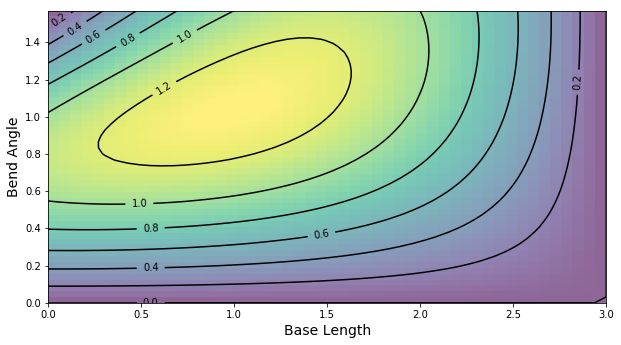

In [2]:
fig, ax = plt.subplots(figsize = (10,6))
CS = ax.contour(b, theta, area,  colors = 'black', antialiased = True)
plt.clabel(CS, inline=1, fmt = '%1.1f', fontsize=10)
plt.imshow(area, extent = [0, 3, 0, np.pi/2], origin = 'lower', cmap='viridis', alpha = 0.6)

# plt.title('Area as function of Base Length and Bend Angle', fontsize=20)
plt.xlabel('Base Length', fontsize=14)
plt.ylabel('Bend Angle', fontsize=14)
plt.show()

From the plot, we see that there is a maximum that is unique over the domain, achieved when $b \approx 1$ and $\theta \approx 1$.

## Question 2: Analytically Solving for b and $\theta$
We can solve for b and $\theta$ analytically using sympy's solve function.

In [3]:
import sympy as sp
from sympy.tensor.array import derive_by_array
from sympy.solvers import solve

b, theta = sp.symbols('b, theta', real = True)

area =  0.5 * (3-b) * sp.sin(theta) * (b + 0.5 * (3-b) * sp.cos(theta))
grad = np.array(derive_by_array(area, (b,theta)))
for i in solve(grad):
    print(f'b is {i[b]}, theta is {i[theta]}')

b is -3.00000000000000, theta is 0.0
b is 1.00000000000000, theta is -1.04719755119660
b is 1.00000000000000, theta is 1.04719755119660
b is 3.00000000000000, theta is 0.0


In [4]:
from sympy.utilities import lambdify
from numpy.linalg import det

hess = lambdify((b,theta), derive_by_array(derive_by_array(area, (b,theta)),(b,theta)))
hess(1, np.pi/3), det(hess(1, np.pi/3))

([[-0.649519052838329, 0.7499999999999999],
  [0.7499999999999998, -2.598076211353316]],
 1.1250000000000004)

The hessian is negative definite, and so $(1, \pi/3)$ is a local maximum.
## Question 3: Numerically Solving for b and $\theta$ using Line Search

In [5]:
import numpy as np
from scipy.optimize import approx_fprime
from numpy.linalg import norm

def func(x):
    return 0.5 * (3-x[0]) * np.sin(x[1]) * (x[0] + 0.5 * (3-x[0]) * np.cos(x[1]))

def bisection(func, x0, maxiter = 10000):
    eps = np.sqrt(np.finfo(float).eps)  
    
    iters = 0  
    x = np.array(x0, dtype=float)
    xs, fs, alphs = x, np.array([func(x)]), np.array([0])
    
    grad = np.ones_like(x)
    
    while norm(grad) > 1e-4 and iters <= maxiter:
        grad = approx_fprime(x, func, eps)
        h = lambda a: -func(x + a*grad)
        
        upper, lower = np.array([0.001]), 0
        
        while approx_fprime(upper, h, eps) <= 0:upper *= 2
        while abs(approx_fprime(((upper + lower)/2), h, eps)) > 1e-6:
            if approx_fprime((upper + lower)/2, h, eps) > 0: upper = (upper + lower)/2
            else: lower = (upper + lower)/2
        
        xs, fs, alphs = np.vstack((xs, x)), np.vstack((fs, func(x))), np.vstack((alphs, (upper + lower) / 2))
        
        x += (upper + lower) / 2*grad
        iters += 1
    
    return(xs, fs, alphs)

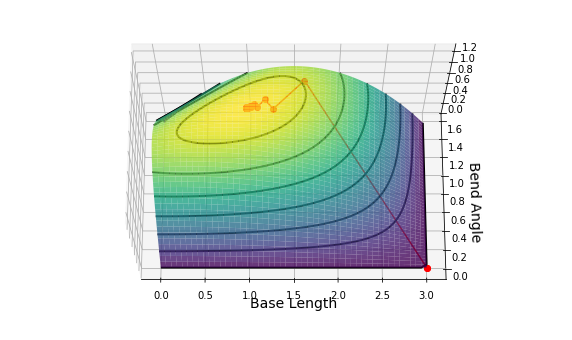

In [16]:
start = np.array([2.9999,0.0001])
xs, fs, alphs = bisection(func, start)

fig = plt.figure(figsize = (10, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(b, theta, area, cmap = 'viridis', linewidth = 0.01, antialiased = True, alpha = 0.8)
cset = ax.contour(b, theta, area, zdir='b',  colors = 'black', linewidths = 2)
ax.view_init(elev=70, azim=-90)
ax.plot(xs[:,0].flatten(), xs[:,1].flatten(), fs.flatten(), 'r-o')

# plt.title('Area as function of Base Length and Bend Angle', fontsize=20)
plt.xlabel('Base Length', fontsize=14)
plt.ylabel('Bend Angle', fontsize=14)
plt.show()

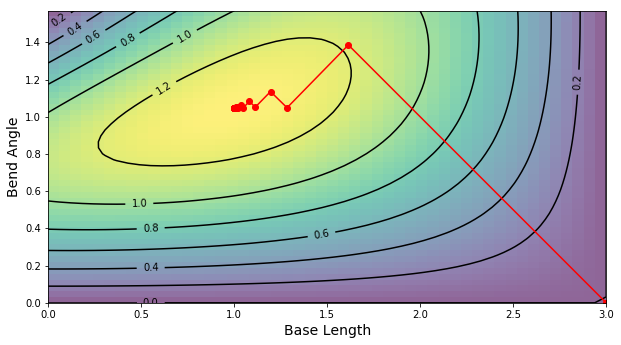

In [17]:
fig, ax = plt.subplots(figsize = (10,6))
CS = ax.contour(b, theta, area,  colors = 'black', antialiased = True)
plt.clabel(CS, inline=1, fmt = '%1.1f', fontsize=10)
plt.imshow(area, extent = [0, 3, 0, np.pi/2], origin = 'lower', cmap='viridis', alpha = 0.6)
plt.plot(xs[:,0], xs[:,1], 'r-o')

# plt.title('Area as function of Base Length and Bend Angle', fontsize=20)
plt.xlabel('Base Length', fontsize=14)
plt.ylabel('Bend Angle', fontsize=14)
plt.show()